In [ ]:
!pip install rasterio tqdm torch torchvision matplotlib

In [ ]:
import os
import rasterio
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize, Resize
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
"""
Dataset Class
"""
class TifImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith(".tif")]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
    # Load the image using rasterio
      img_name = self.image_names[idx]
      img_path = os.path.join(self.image_dir, img_name)
      with rasterio.open(img_path) as src:
          image = src.read()  # Read all bands

      # Convert image to PyTorch tensor
      image = torch.tensor(image, dtype=torch.float32)

      # Fix NaN values
      for band in range(image.shape[0]):  # Iterate over bands
          band_data = image[band, :, :]
          nan_mask = torch.isnan(band_data)
          if nan_mask.any():
              mean_value = band_data[~nan_mask].mean()  # Mean of non-NaN values
              band_data[nan_mask] = mean_value  # Replace NaN with the mean

      # Ensure 3-channel image for consistency
      if image.shape[0] == 3:
          pass
      elif image.shape[0] > 3:
          image = image[:3, :, :]
      else:
          image = image.expand(3, image.shape[1], image.shape[2])

      # Load the corresponding mask
      mask_name = img_name.replace(".tif", "_mask.tif")
      mask_path = os.path.join(self.mask_dir, mask_name)
      with rasterio.open(mask_path) as src:
          mask = src.read(1)  # Read single channel for binary mask

      # Calculate the number of zeros and non-zeros in the mask
      total_pixels = mask.size  # Total number of pixels in the mask
      non_zero_pixels = (mask > 0).sum()  # Count of non-zero pixels
      non_zero_percentage = (non_zero_pixels / total_pixels) * 100

      # Determine label based on non-zero percentage
      label = torch.tensor(1 if non_zero_percentage > 30 else 0, dtype=torch.long)

      # Apply transforms if provided
      if self.transform:
          image = self.transform(image)

      return image, label

In [ ]:
from torchvision.transforms import Compose, Normalize, Resize

# Define transformations with augmentations
input_size = 224  # Required input size for ViT
transform = Compose([
    Resize((input_size, input_size)),            # Resize to ViT-compatible dimensions
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))     # ImageNet normalization
])

# Initialize dataset
image_dir = "sar-ds-r-filtered-bal/sar_ds_r_filtered_bal/image_patches"
mask_dir = "sar-ds-r-filtered-bal/sar_ds_r_filtered_bal/mask_patches"
dataset = TifImageDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)

# Example to check output
for image, label in dataset:
    print(f"Image shape before processing: {image.shape}, Label: {label}")
    break

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset,ConcatDataset
import numpy as np
# Separate the dataset into two subsets based on labels (0 and 1)
label_0_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]
label_1_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]

# Random split for label 0

Image shape before processing: torch.Size([3, 224, 224]), Label: 1


In [3]:
from torch.utils.data import Subset,ConcatDataset
train_indices_0, val_indices_0 = train_test_split(
    label_0_indices, test_size=0.2, random_state=42
)

# Random split for label 1
train_indices_1, val_indices_1 = train_test_split(
    label_1_indices, test_size=0.2, random_state=42
)

# Create subsets for training and validation
train_subset_0 = Subset(dataset, train_indices_0)
train_subset_1 = Subset(dataset, train_indices_1)
val_subset_0 = Subset(dataset, val_indices_0)
val_subset_1 = Subset(dataset, val_indices_1)

# Merge training and validation subsets
train_dataset = ConcatDataset([train_subset_0, train_subset_1])
val_dataset = ConcatDataset([val_subset_0, val_subset_1])

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

#print(f"Training samples: {train_size}, Validation samples: {val_size}")

for image, label in train_loader:
    print(f"Image shape after processing: {image.shape}, Label: {label}")
    break
print(torch.cuda.is_available())
print(torch.version.cuda)

Image shape after processing: torch.Size([8, 3, 224, 224]), Label: tensor([1, 1, 1, 1, 1, 0, 0, 1])
True
12.1


In [ ]:
import os
import pickle
import torch
from collections import Counter
from torchvision import models
from tqdm import tqdm
from timm import create_model
from torch import nn, optim
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error
import pandas as pd


model = models.vit_l_16(weights=models.ViT_L_16_Weights.DEFAULT)  # ViT Large with 16x16 patches
num_classes = 2
model.heads.head = torch.nn.Linear(model.heads.head.in_features, num_classes)

# Enable DataParallel for multi-GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs...")
    model = torch.nn.DataParallel(model)

model.to(device)

# Check class distribution
class_counts = Counter(label.item() for _, label in dataset)
print(f"Class distribution: {class_counts}")

class_weights = torch.tensor([1.0, len(dataset) / class_counts[1]], device=device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Initialize lists to store metrics
metrics_history = []
checkpoint_dir = ""
#os.makedirs(checkpoint_dir, exist_ok=True)  # Create directory if it doesn't exist
metrics_csv_path = os.path.join(checkpoint_dir, "metrics_history_filtered_L.csv")

best_val = 0.0  # To track the best model
best_train = 0.0 
# Training loop with checkpoint saving
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")
    for batch_idx, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            "Batch Loss": f"{loss.item():.4f}",
            "Batch Accuracy": f"{100 * correct / total:.2f}%"
        })

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_val_labels = []
    all_val_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_val_labels.extend(labels.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_precision = precision_score(all_val_labels, all_val_predictions, average='weighted')
    val_recall = recall_score(all_val_labels, all_val_predictions, average='weighted')
    val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted')

    # Save metrics
    metrics_history.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "val_precision": val_precision,
        "val_recall": val_recall,
        "val_f1_score": val_f1,
    })

    metrics_df = pd.DataFrame(metrics_history)
    metrics_df.to_csv(metrics_csv_path, index=False)

    print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_precision:.2f}, "
          f"Val Recall: {val_recall:.2f}, Val F1 Score: {val_f1:.2f}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val:
        best_accuracy = val_accuracy
        best_model_path = os.path.join(checkpoint_dir, "best_model_filtered_L_val.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': val_accuracy,
        }, best_model_path)
        print(f"Best model updated with validation accuracy: {best_accuracy:.2f}%")
    if train_accuracy > best_train:
        best_accuracy = train_accuracy
        best_model_path = os.path.join(checkpoint_dir, "best_model_filtered_L_train.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'accuracy': train_accuracy,
        }, best_model_path)
        print(f"Best model updated with train accuracy: {best_accuracy:.2f}%")

print("Training complete. Checkpoints and metrics saved.")


Using 2 GPUs...
Class distribution: {1: 3496, 0: 3496}


Epoch 1/15: 100%|██████████| 699/699 [10:21<00:00,  1.12it/s, Batch Loss=0.1145, Batch Accuracy=83.80%]


Epoch [1/15] - Train Loss: 0.3529, Train Accuracy: 83.80%, Val Loss: 0.2799, Val Accuracy: 89.07%, Val Precision: 0.89, Val Recall: 0.89, Val F1 Score: 0.89
Best model updated with validation accuracy: 89.07%
Best model updated with train accuracy: 83.80%


Epoch 2/15: 100%|██████████| 699/699 [10:25<00:00,  1.12it/s, Batch Loss=0.3230, Batch Accuracy=88.77%]


Epoch [2/15] - Train Loss: 0.2516, Train Accuracy: 88.77%, Val Loss: 0.2392, Val Accuracy: 89.36%, Val Precision: 0.90, Val Recall: 0.89, Val F1 Score: 0.89
Best model updated with validation accuracy: 89.36%
Best model updated with train accuracy: 88.77%


Epoch 3/15: 100%|██████████| 699/699 [10:26<00:00,  1.12it/s, Batch Loss=0.1593, Batch Accuracy=90.02%]


Epoch [3/15] - Train Loss: 0.2125, Train Accuracy: 90.02%, Val Loss: 0.1714, Val Accuracy: 92.86%, Val Precision: 0.93, Val Recall: 0.93, Val F1 Score: 0.93
Best model updated with validation accuracy: 92.86%
Best model updated with train accuracy: 90.02%


Epoch 4/15: 100%|██████████| 699/699 [10:26<00:00,  1.12it/s, Batch Loss=0.1560, Batch Accuracy=91.56%]


Epoch [4/15] - Train Loss: 0.1829, Train Accuracy: 91.56%, Val Loss: 0.1802, Val Accuracy: 93.07%, Val Precision: 0.93, Val Recall: 0.93, Val F1 Score: 0.93
Best model updated with validation accuracy: 93.07%
Best model updated with train accuracy: 91.56%


Epoch 5/15: 100%|██████████| 699/699 [10:25<00:00,  1.12it/s, Batch Loss=0.0156, Batch Accuracy=92.17%]


Epoch [5/15] - Train Loss: 0.1697, Train Accuracy: 92.17%, Val Loss: 0.2646, Val Accuracy: 87.93%, Val Precision: 0.90, Val Recall: 0.88, Val F1 Score: 0.88
Best model updated with validation accuracy: 87.93%
Best model updated with train accuracy: 92.17%


Epoch 6/15: 100%|██████████| 699/699 [10:22<00:00,  1.12it/s, Batch Loss=0.0347, Batch Accuracy=92.20%]


Epoch [6/15] - Train Loss: 0.1606, Train Accuracy: 92.20%, Val Loss: 0.2029, Val Accuracy: 91.36%, Val Precision: 0.92, Val Recall: 0.91, Val F1 Score: 0.91
Best model updated with validation accuracy: 91.36%
Best model updated with train accuracy: 92.20%


Epoch 7/15: 100%|██████████| 699/699 [10:22<00:00,  1.12it/s, Batch Loss=0.0165, Batch Accuracy=92.61%]


Epoch [7/15] - Train Loss: 0.1521, Train Accuracy: 92.61%, Val Loss: 0.1685, Val Accuracy: 93.00%, Val Precision: 0.93, Val Recall: 0.93, Val F1 Score: 0.93
Best model updated with validation accuracy: 93.00%
Best model updated with train accuracy: 92.61%


Epoch 8/15: 100%|██████████| 699/699 [10:27<00:00,  1.11it/s, Batch Loss=0.0874, Batch Accuracy=93.90%]


Epoch [8/15] - Train Loss: 0.1328, Train Accuracy: 93.90%, Val Loss: 0.2113, Val Accuracy: 92.14%, Val Precision: 0.92, Val Recall: 0.92, Val F1 Score: 0.92
Best model updated with validation accuracy: 92.14%
Best model updated with train accuracy: 93.90%


Epoch 9/15: 100%|██████████| 699/699 [10:30<00:00,  1.11it/s, Batch Loss=0.0005, Batch Accuracy=94.15%]


Epoch [9/15] - Train Loss: 0.1259, Train Accuracy: 94.15%, Val Loss: 0.1867, Val Accuracy: 93.57%, Val Precision: 0.94, Val Recall: 0.94, Val F1 Score: 0.94
Best model updated with validation accuracy: 93.57%
Best model updated with train accuracy: 94.15%


Epoch 10/15: 100%|██████████| 699/699 [10:32<00:00,  1.11it/s, Batch Loss=0.0210, Batch Accuracy=93.42%]


Epoch [10/15] - Train Loss: 0.1434, Train Accuracy: 93.42%, Val Loss: 0.1977, Val Accuracy: 92.64%, Val Precision: 0.93, Val Recall: 0.93, Val F1 Score: 0.93
Best model updated with validation accuracy: 92.64%
Best model updated with train accuracy: 93.42%


Epoch 11/15: 100%|██████████| 699/699 [10:30<00:00,  1.11it/s, Batch Loss=0.3985, Batch Accuracy=94.46%]


Epoch [11/15] - Train Loss: 0.1220, Train Accuracy: 94.46%, Val Loss: 0.1809, Val Accuracy: 92.57%, Val Precision: 0.93, Val Recall: 0.93, Val F1 Score: 0.93
Best model updated with validation accuracy: 92.57%
Best model updated with train accuracy: 94.46%


Epoch 12/15: 100%|██████████| 699/699 [10:29<00:00,  1.11it/s, Batch Loss=0.0467, Batch Accuracy=96.07%]


Epoch [12/15] - Train Loss: 0.0922, Train Accuracy: 96.07%, Val Loss: 0.1847, Val Accuracy: 93.57%, Val Precision: 0.94, Val Recall: 0.94, Val F1 Score: 0.94
Best model updated with validation accuracy: 93.57%
Best model updated with train accuracy: 96.07%


Epoch 13/15: 100%|██████████| 699/699 [10:29<00:00,  1.11it/s, Batch Loss=0.0081, Batch Accuracy=96.37%]


Epoch [13/15] - Train Loss: 0.0767, Train Accuracy: 96.37%, Val Loss: 0.2009, Val Accuracy: 92.64%, Val Precision: 0.93, Val Recall: 0.93, Val F1 Score: 0.93
Best model updated with validation accuracy: 92.64%
Best model updated with train accuracy: 96.37%


Epoch 14/15: 100%|██████████| 699/699 [10:23<00:00,  1.12it/s, Batch Loss=0.0003, Batch Accuracy=96.57%]


Epoch [14/15] - Train Loss: 0.0748, Train Accuracy: 96.57%, Val Loss: 0.2591, Val Accuracy: 92.14%, Val Precision: 0.93, Val Recall: 0.92, Val F1 Score: 0.92
Best model updated with validation accuracy: 92.14%
Best model updated with train accuracy: 96.57%


Epoch 15/15: 100%|██████████| 699/699 [10:23<00:00,  1.12it/s, Batch Loss=0.0302, Batch Accuracy=97.28%]


Epoch [15/15] - Train Loss: 0.0639, Train Accuracy: 97.28%, Val Loss: 0.2884, Val Accuracy: 91.00%, Val Precision: 0.92, Val Recall: 0.91, Val F1 Score: 0.91
Best model updated with validation accuracy: 91.00%
Best model updated with train accuracy: 97.28%
Training complete. Checkpoints and metrics saved.


In [ ]:
"""
Testing the model
"""
import os
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, Normalize
from torchvision import models
from collections import OrderedDict

# Define a separate preprocessing function
def preprocess_image(image_path, transform):
    """
    Loads a TIFF image from `image_path`, fixes NaNs, ensures a 3-channel tensor,
    applies the provided transform, and returns both the transformed image tensor (with batch dim)
    and a copy for display.
    """
    # Load the image using rasterio
    with rasterio.open(image_path) as src:
        image = src.read()  # shape: [bands, height, width]

    # Convert to a float32 torch tensor
    image = torch.tensor(image, dtype=torch.float32)

    # Fix NaN values for each band
    for band in range(image.shape[0]):
        band_data = image[band]
        nan_mask = torch.isnan(band_data)
        if nan_mask.any():
            mean_value = band_data[~nan_mask].mean()
            band_data[nan_mask] = mean_value

    # Ensure the image has exactly 3 channels
    if image.shape[0] == 3:
        pass
    elif image.shape[0] > 3:
        image = image[:3, :, :]
    else:
        image = image.expand(3, image.shape[1], image.shape[2])

    # Save a copy for display (before applying normalization)
    display_image = image.clone()

    # Apply the provided transformations (e.g., resizing and normalization)
    image = transform(image)

    # Add a batch dimension
    image = image.unsqueeze(0)
    
    return image, display_image

# Define the transformation (same as used during training)
input_size = 224
transform = Compose([
    Resize((input_size, input_size)),  # Resize image to model input size
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # ImageNet normalization
])

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs...")
    model = torch.nn.DataParallel(model)
# Load the pre-trained ViT model and adjust the classification head for 2 classes
model = models.vit_l_16(weights=None)
num_classes = 2
model.heads.head = torch.nn.Linear(model.heads.head.in_features, num_classes)
model.to(device)
model.eval()

# Load the saved model checkpoint
checkpoint_path = "model_pretrained_weights/model.pth"  # update with your checkpoint path
checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=True)
state_dict = checkpoint['model_state_dict']

# Remove 'module.' prefix from state dict keys if present
new_state_dict = OrderedDict()
for key, value in state_dict.items():
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value

# Load the modified state dict into the model
model.load_state_dict(new_state_dict)

Using 2 GPUs...
Prediction: Class 1 with confidence 0.93


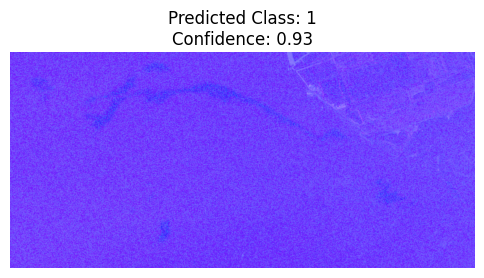

In [ ]:

"""
Testing a sample .tif iamge which belongs to Class 1
"""
# Path to the single TIFF file you want to predict
image_path = "input/oil-spill-test/one.tif"  # update with your image path

# Preprocess the image
input_tensor, display_tensor = preprocess_image(image_path, transform)
input_tensor = input_tensor.to(device)

# Make a prediction
with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][predicted_class].item()

print(f"Prediction: Class {predicted_class} with confidence {confidence:.2f}")

# Prepare the image for display
# Convert tensor (3, H, W) to numpy array (H, W, 3) and normalize for display purposes
display_image = display_tensor.cpu().numpy()
display_image = np.transpose(display_image, (1, 2, 0))
# Normalize values to [0,1] for plotting (this is only for visualization)
display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min() + 1e-5)

# Display the image along with the prediction
plt.figure(figsize=(6,6))
plt.imshow(display_image)
plt.title(f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()

Prediction: Class 0 with confidence 0.98


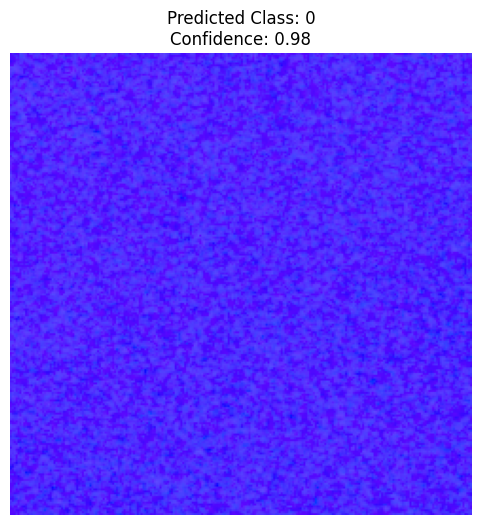

In [ ]:
"""
Testing a sample .tif iamge which belongs to Class 0
"""
# Path to the single TIFF file you want to predict
image_path = "input/oil-spill-test/zero.tif"  # update with your image path

# Preprocess the image
input_tensor, display_tensor = preprocess_image(image_path, transform)
input_tensor = input_tensor.to(device)

# Make a prediction
with torch.no_grad():
    outputs = model(input_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0][predicted_class].item()

print(f"Prediction: Class {predicted_class} with confidence {confidence:.2f}")

# Prepare the image for display
# Convert tensor (3, H, W) to numpy array (H, W, 3) and normalize for display purposes
display_image = display_tensor.cpu().numpy()
display_image = np.transpose(display_image, (1, 2, 0))
# Normalize values to [0,1] for plotting (this is only for visualization)
display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min() + 1e-5)

# Display the image along with the prediction
plt.figure(figsize=(6,6))
plt.imshow(display_image)
plt.title(f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis("off")
plt.show()